In [81]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
import os
import graphviz

# Define the path to the Graphviz executable
graphviz_path = r"C:\Users\vgiddaluri\Graphviz\bin"
os.environ["PATH"] += os.pathsep + graphviz_path

# Verify if dot.exe exists in the specified path
dot_executable = os.path.join(graphviz_path, 'dot.exe')
if not os.path.isfile(dot_executable):
    raise FileNotFoundError(f"The file {dot_executable} does not exist. Please check the path.")

# Configure graphviz to use the specified executable
graphviz.set_default_engine('dot')
graphviz.set_default_format('pdf')

# Your existing code to generate the graph
dot = graphviz.Digraph(comment='The Round Table')
dot.node('A', 'King Arthur')
dot.node('B', 'Sir Bedevere the Wise')
dot.node('L', 'Sir Lancelot the Brave')
dot.edges(['AB', 'AL'])
dot.edge('B', 'L', constraint='false')
print(dot.source)

// The Round Table
digraph {
	A [label="King Arthur"]
	B [label="Sir Bedevere the Wise"]
	L [label="Sir Lancelot the Brave"]
	A -> B
	A -> L
	B -> L [constraint=false]
}



In [83]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [84]:
#PYTORCH Code for backprogression analysis

class Value:

    def __init__(self, data, _children = (), _op="", label = ""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"value ={self.data}"
    
    def __add__(self, other):
        other = other  if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children=(self, other), _op="+")
        def _backward():
            self.grad += 1*out.grad
            other.grad += 1*out.grad
        out._backward =_backward
        return out
    
    def __mul__(self, other):
        other = other  if isinstance(other, Value) else Value(other)
        out = Value((self.data * other.data), _children=(self, other), _op="*")
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        return out 
    
    def tanh(self):
        n = self.data
        x = (math.exp(2*n)-1) / (math.exp(2*n)+1)
        out = Value(x, _children = (self,), _op= "tanh")
        def _backward():
            self.grad += out.grad*(1-(x**2))
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'** {other}')
        def _backward():
            self.grad += other*(self.data**(other-1))* out.grad
        out._backward = _backward 
        return out

    def exp(self):
        out = Value((math.exp(self.data)), _children=(self,), _op="exp")
        def _backward():
            self.grad += out.data*out.grad
        out._backward = _backward
        return out 
    
    def __truediv__(self, other):
        to_pow_neg1 = other**-1
        return self * (to_pow_neg1)
    
    def __rmul__(self, other):
        # Define multiplication behavior for Value * Value
        return self * other
    
    def __radd__(self, other):
        # Define multiplication behavior for Value * Value
        return self + other
    
    #create a function that calls the list backwards
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        self.grad = 1.0
        build_topo(self)
        for node in reversed(topo):
            node._backward()

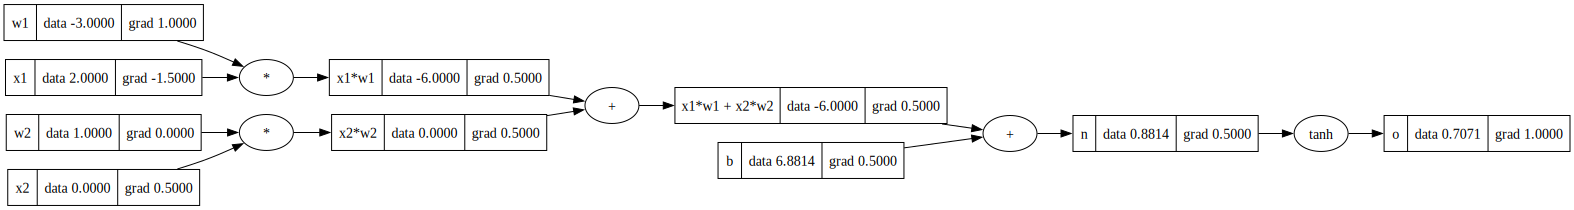

In [85]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh();o.label = 'o'

o.backward()
draw_dot(o)

value =0.7071067811865477


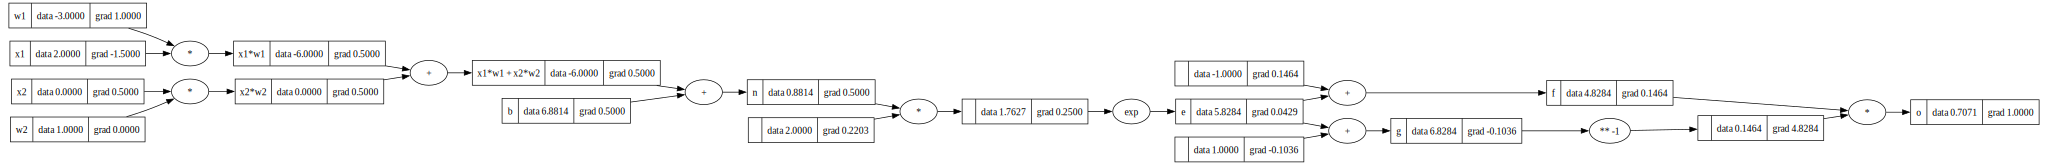

In [86]:
    # inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp(); e.label = 'e'
f = (e-1); f.label = 'f'
g = (e+1); g.label = 'g'
o = f/g; o.label = 'o'
print(o)
o.backward()
draw_dot(o)